### Privatizing Histograms

Sometimes we want to release the counts of individual outcomes in a dataset.
When plotted, this makes a histogram.

The library currently has two approaches:
1. Known category set `make_count_by_categories`
2. Unknown category set `make_count_by`

The next code block imports just handles boilerplate: imports, data loading, plotting.

In [1]:
import os

from opendp.trans import *
from opendp.meas import *
from opendp.typing import *

# public information
col_names = ["age", "sex", "educ", "race", "income", "married"]

data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')

with open(data_path) as input_data:
    data = input_data.read()

def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    plt.ylim([0,225])
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xlim(0,15)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')
    ax.legend()
    plt.title('Histogram of Income')
    plt.xlabel('Income, in thousands')
    plt.ylabel('Count')
    plt.show()

### Private histogram via `make_count_by_categories`

This approach is only applicable if the set of potential values that the data may take on is public information.
If this information is not available, then use `make_count_by` instead.
In this data, we know that the categories set is public information:
strings consisting of the numbers between 1 and 20.

The counting aggregator computes a vector of counts in the same order as the input categories.
It also includes one extra count at the end of the vector,
consisting of the number of elements that were not in the category set.

You'll notice that `make_base_geometric` has an additional argument that explicitly sets the type of the domain, `D`.
It defaults to `AllDomain[int]` which works in situations where the mechanism is noising a scalar.
However, in this situation, we are noising a vector of scalars,
and thus the appropriate domain is `VectorDomain[AllDomain[int]]`.

Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0]
DP Educational level counts:
 [32, 14, 38, 15, 24, 20, 29, 51, 198, 59, 166, 76, 178, 53, 22, 12, 5, 0, -1]
DP estimate for the number of records that were not a member of the category set: -3


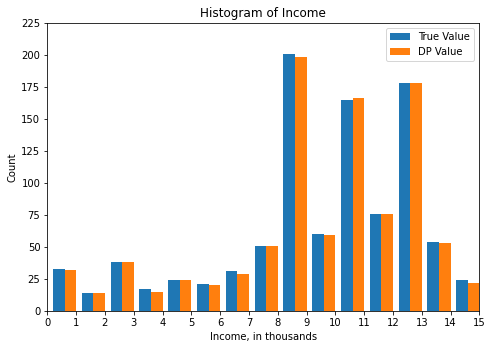

In [2]:
# public information
categories = list(map(str, range(1, 20)))

histogram = (
    make_split_dataframe(separator=",", col_names=col_names) >>
    make_select_column(key="educ", TOA=str) >>
    # Compute counts for each of the categories and null
    make_count_by_categories(categories=categories)
)

noisy_histogram = histogram >> make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)

print("Educational level counts:\n", sensitive_counts[:-1])
print("DP Educational level counts:\n", released_counts[:-1])

print("DP estimate for the number of records that were not a member of the category set:", released_counts[-1])

plot_histogram(sensitive_counts, released_counts)

### Private histogram via `make_count_by`
This approach is applicable when the set of categories is unknown.

The stability mechanism, as currently written, samples from a continuous noise distribution,
If you haven't already, please read about [floating-point behavior in the docs](https://docs.opendp.org/en/latest/user/measurement-constructors.html#floating-point).


Educational level counts:
 {'11': 165, '1': 33, '4': 17, '9': 201, '3': 38, '7': 31, '14': 54, '10': 60, '2': 14, '15': 24, '6': 21, '16': 13, '8': 51, '13': 178, '5': 24, '12': 76}
DP Educational level counts:
 {'6': 21, '14': 52, '11': 166, '3': 39, '8': 53, '13': 178, '12': 77, '9': 202, '7': 31, '1': 32, '15': 24, '5': 25, '10': 60}


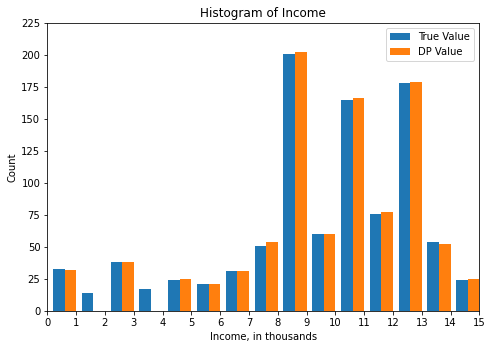

In [3]:
from opendp.mod import enable_features
enable_features("floating-point")

histogram = (
    make_split_dataframe(separator=",", col_names=col_names) >>
    make_select_column(key="educ", TOA=str) >>
    make_resize(size=1000, constant="-1") >>
    # Compute counts for all unique values in the data
    make_count_by(size=1000, TIA=str, MO=L1Distance[float])
)

noisy_histogram = histogram >> make_base_stability(size=1000, scale=1., threshold=20., MI=L1Distance[float], TIK=str)

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)
# postprocess to make the results easier to compare
postprocessed_counts = {k: round(v) for k, v in released_counts.items()}

print("Educational level counts:\n", sensitive_counts)
print("DP Educational level counts:\n", postprocessed_counts)

def as_array(data):
    return [data.get(k, 0) for k in categories]

plot_histogram(as_array(sensitive_counts), as_array(released_counts))